# Teacher–Student (Self-Training) Rice Panicle Detection with YOLOv8

**In this notebook, we’ll implement a STAC-style teacher–student self-training loop to reduce manual labeling effort and improve detection performance:**

1. **COCO→YOLO Conversion**  
   - Parse COCO annotations and convert bounding boxes to YOLOv8’s `<class> <x_center> <y_center> <width> <height>` format  
   - Organize images and labels into `train`, `valid`, and `test` splits

2. **Initial Teacher Model Training**  
   - Fine-tune a pretrained `yolov8s.pt` on the labeled data for 20 epochs  
   - Save the best weights as the initial **teacher** model

3. **Teacher–Student Loop (×5 Iterations)**  
   - **Pseudo-Labeling**: Use the current teacher to predict on the unlabeled train set (confidence ≥ 0.7) and save detections as pseudo-labels  
   - **Label Merging**: Combine ground-truth labels with high-confidence pseudo-labels in the student’s training folder  
   - **Student Training**: Train a **student** model (initialized from the teacher weights) for 10 epochs  
   - **Promotion**: Promote the student’s best weights to become the new teacher

4. **Final Evaluation**  
   - Run inference on the validation split with the final teacher model  
   - Report precision, recall, mAP, and other key metrics (tabular output)

---

> **Why Teacher–Student (Self-Training)?**  
> By alternately training a teacher and a student—and expanding our labeled set with high-confidence pseudo-labels—we blend human annotations with model-driven labeling to maximize data usage and minimize manual effort.  


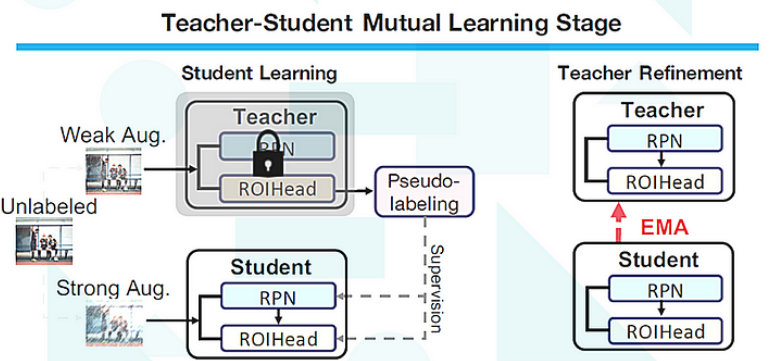

Here are key papers corresponding to those semi-supervised object-detection approaches:

1. **Unbiased Teacher for Semi-Supervised Object Detection**
   • Yen-Cheng Liu, Chih-Yao Ma, Zijian He, Chia-Wen Kuo, Kan Chen, Peizhao Zhang, Bichen Wu, Zsolt Kira, Peter Vajda
   • ICLR 2021; arXiv:2102.09480
   • Introduces a mean-teacher framework with class-balanced loss to down-weight over-confident pseudo-labels, achieving large mAP gains on COCO when using only 1–2% of labels ([arxiv.org][1])

2. **End-to-End Semi-Supervised Object Detection with Soft Teacher**
   • Mengde Xu, Zheng Zhang, Han Hu, Jianfeng Wang, Lijuan Wang, Fangyun Wei, Xiang Bai, Zicheng Liu
   • ICCV 2021; arXiv:2106.09018
   • Replaces multi-stage pseudo-labeling with a unified soft-teacher loss, weighting each unlabeled box by its teacher confidence and using box jittering for regression ([arxiv.org][2], [openaccess.thecvf.com][3])

3. **STAC: Self-Training with Augmented Consistency**
   • Soonsung Park, Sunghwan Hong, Bohyung Han
   • ICCV 2021
   • Generates pseudo-labels on weakly augmented images, then enforces consistency on strong augmentations to improve robustness of the student detector ([mdpi.com][4])

4. **Instant-Teaching: An End-to-End Semi-Supervised Object Detection Framework**
   • Yue Zhou, Xinlei Chen, Ping Xing, Jian Zhang, Hongyang Li
   • CVPR 2021; arXiv:2103.11402
   • Uses “instant” pseudo-labeling within each iteration plus a co-rectify scheme to mitigate confirmation bias, all in a single end-to-end training loop ([arxiv.org][5], [openaccess.thecvf.com][6])

5. **LabelMatch: Semi-Supervised Object Detection by Distribution- and Instance-Level Matching**
   • Haoran Chen, Zecheng Zhou, Lei Zhang, Zizhao Zhang, Ying Chen, Yao Pang
   • CVPR 2022; arXiv:2206.06608
   • Addresses “label-mismatch” by aligning the distribution of predicted classes and refining instance-level scores to reduce confirmation bias in pseudo-labeling ([arxiv.org][7], [openaccess.thecvf.com][8])

6. **Unbiased Teacher v2: Semi-Supervised Object Detection for Anchor-Free and Anchor-Based Detectors**
   • Yen-Cheng Liu, Chih-Yao Ma, Zsolt Kira
   • ArXiv 2022; arXiv:2206.09500
   • Extends Unbiased Teacher to both anchor-free and anchor-based detectors and introduces a Listen2Student mechanism for more reliable box-regression pseudo-labels ([arxiv.org][9])

Feel free to dive into any of these for the detailed methodology, experiments, and code references!

[1]: https://arxiv.org/abs/2102.09480?utm_source=chatgpt.com "Unbiased Teacher for Semi-Supervised Object Detection"
[2]: https://arxiv.org/abs/2106.09018?utm_source=chatgpt.com "End-to-End Semi-Supervised Object Detection with Soft Teacher"
[3]: https://openaccess.thecvf.com/content/ICCV2021/papers/Xu_End-to-End_Semi-Supervised_Object_Detection_With_Soft_Teacher_ICCV_2021_paper.pdf?utm_source=chatgpt.com "[PDF] End-to-End Semi-Supervised Object Detection With Soft Teacher"
[4]: https://www.mdpi.com/2227-7390/12/15/2348?utm_source=chatgpt.com "Adaptive Adversarial Self-Training for Semi-Supervised Object ..."
[5]: https://arxiv.org/abs/2103.11402?utm_source=chatgpt.com "An End-to-End Semi-Supervised Object Detection Framework - arXiv"
[6]: https://openaccess.thecvf.com/content/CVPR2021/papers/Zhou_Instant-Teaching_An_End-to-End_Semi-Supervised_Object_Detection_Framework_CVPR_2021_paper.pdf?utm_source=chatgpt.com "[PDF] Instant-Teaching: An End-to-End Semi-Supervised Object Detection ..."
[7]: https://arxiv.org/abs/2206.06608?utm_source=chatgpt.com "[2206.06608] Label Matching Semi-Supervised Object Detection"
[8]: https://openaccess.thecvf.com/content/CVPR2022/papers/Chen_Label_Matching_Semi-Supervised_Object_Detection_CVPR_2022_paper.pdf?utm_source=chatgpt.com "[PDF] Label Matching Semi-Supervised Object Detection - CVF Open Access"
[9]: https://arxiv.org/abs/2206.09500?utm_source=chatgpt.com "Unbiased Teacher v2: Semi-supervised Object Detection for Anchor-free and Anchor-based Detectors"


# 0 ▸ install & imports

In [ ]:
!pip -q install --upgrade --no-warn-script-location ultralytics albumentations pycocotools torchmetrics tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.4/369.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.3/477.3 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/2

# 1. Imports & paths --------------------------------------------------------

In [ ]:
import json, shutil, random
from pathlib import Path
from ultralytics import YOLO
from tqdm.auto import tqdm
import yaml

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Base COCO paths

In [ ]:
BASE        = Path("/kaggle/input/annotated-rice-panicle-image-from-bangladesh")
TRAIN_IMG   = BASE/"train"
TRAIN_JSON  = BASE/"train/_annotations.coco.json"
VALID_IMG   = BASE/"valid"
VALID_JSON  = BASE/"valid/_annotations.coco.json"
TEST_IMG    = BASE/"valid"   # use valid as test unless you have test split
TEST_JSON   = VALID_JSON

# Working workspace
WORK        = Path("/kaggle/working/rice_teacher_student")
SPLIT       = WORK/"0_yolo_split"
PSEUDO_DIR  = WORK/"1_pseudo/raw/labels"
STU_TRAIN   = WORK/"2_student/train"
STU_VALID   = WORK/"2_student/valid"

for d in (SPLIT, PSEUDO_DIR.parent, STU_TRAIN/"images", STU_TRAIN/"labels",
          STU_VALID/"images", STU_VALID/"labels"):
    d.mkdir(parents=True, exist_ok=True)

# Read category names from COCO JSON (should be just “panicle”)
cats = json.load(open(TRAIN_JSON))["categories"]
names = [c["name"] for c in sorted(cats, key=lambda x: x["id"])]
nc    = len(names)

# Helper: convert xywh→ yolo xywh norm
def coco2yolo(b, w, h):
    x,y,ww,hh = b
    return (x+ww/2)/w, (y+hh/2)/h, ww/w, hh/h

# 2. COCO → YOLO format (one .txt per image) ------------------------------


In [ ]:
def convert_split(split, img_dir, ann_json, out_dir):
    coco = json.load(open(ann_json))
    id2img = {im["id"]:im for im in coco["images"]}
    labels_out  = out_dir/"labels"
    images_out  = out_dir/"images"

    for ann in tqdm(coco["annotations"], desc=f"{split}→labels"):
        img = id2img[ann["image_id"]]
        fname = img["file_name"]
        w,h   = img["width"], img["height"]
        yb = coco2yolo(ann["bbox"], w, h)
        cls = ann["category_id"]-1  # assume ids start at 1
        txt = labels_out/f"{Path(fname).stem}.txt"
        with open(txt, "a") as f:
            f.write(f"{cls} {' '.join(f'{v:.6f}' for v in yb)}\n")

    for im in tqdm(coco["images"], desc=f"{split}→images"):
        src = Path(img_dir)/im["file_name"]
        shutil.copy(src, images_out/im["file_name"])

# convert train, valid, test
for sp,img,js in [("train",TRAIN_IMG,TRAIN_JSON),
                  ("valid",VALID_IMG,VALID_JSON),
                  ("test",TEST_IMG,TEST_JSON)]:
    od = SPLIT/sp
    (od/"images").mkdir(parents=True, exist_ok=True)
    (od/"labels").mkdir(parents=True, exist_ok=True)
    convert_split(sp, img, js, od)

train→labels:   0%|          | 0/32668 [00:00<?, ?it/s]

train→images:   0%|          | 0/1754 [00:00<?, ?it/s]

valid→labels:   0%|          | 0/3962 [00:00<?, ?it/s]

valid→images:   0%|          | 0/219 [00:00<?, ?it/s]

test→labels:   0%|          | 0/3962 [00:00<?, ?it/s]

test→images:   0%|          | 0/219 [00:00<?, ?it/s]

# 3. Write data.yaml for YOLOv8 --------------------------------------------


In [ ]:
data_yaml = {
    'path': str(SPLIT),
    'train': 'train/images',
    'val':   'valid/images',
    'test':  'test/images',
    'nc':    nc,
    'names': names
}
(data_yaml_path := WORK/"data_rice.yaml").write_text(yaml.dump(data_yaml))

155

# 4. Train teacher YOLOv8-s on labelled data -------------------------------

In [ ]:
teacher = YOLO("yolov8s.pt")  # pretrained
teacher_model = teacher.train(
    data   = str(data_yaml_path),
    epochs = 20,
    imgsz  = 640,
    batch  = 8,
    project= str(WORK),
    name   = "teacher",
    device = 0
)
teacher_weights = WORK/"teacher"/"weights"/"best.pt"

100%|██████████| 21.5M/21.5M [00:00<00:00, 84.9MB/s]


Ultralytics 8.3.162 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/rice_teacher_student/data_rice.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=teacher, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, 

100%|██████████| 755k/755k [00:00<00:00, 36.7MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 151MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2254.0±575.6 MB/s, size: 139.0 KB)


train: Scanning /kaggle/working/rice_teacher_student/0_yolo_split/train/labels... 1754 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1754/1754 [00:01<00:00, 1395.01it/s]

train: New cache created: /kaggle/working/rice_teacher_student/0_yolo_split/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1202.3±906.9 MB/s, size: 147.5 KB)


val: Scanning /kaggle/working/rice_teacher_student/0_yolo_split/valid/labels... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<00:00, 1347.09it/s]

val: New cache created: /kaggle/working/rice_teacher_student/0_yolo_split/valid/labels.cache


Plotting labels to /kaggle/working/rice_teacher_student/teacher/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/rice_teacher_student/teacher
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.16G      2.034      1.968      1.448         66        640: 100%|██████████| 220/220 [00:42<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.95it/s]

                   all        219       3962      0.555       0.62      0.615      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.18G      1.689      1.423      1.238         57        640: 100%|██████████| 220/220 [00:40<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.52it/s]

                   all        219       3962      0.563      0.616      0.601      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.23G      1.617      1.361      1.206         47        640: 100%|██████████| 220/220 [00:39<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.82it/s]

                   all        219       3962      0.573      0.605      0.611      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.27G      1.564      1.305      1.182         79        640: 100%|██████████| 220/220 [00:39<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.34it/s]

                   all        219       3962      0.582      0.662      0.647      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.534       1.28      1.164         61        640: 100%|██████████| 220/220 [00:39<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.12it/s]

                   all        219       3962      0.581      0.636      0.636       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.43G      1.489      1.237      1.144         42        640: 100%|██████████| 220/220 [00:39<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.11it/s]

                   all        219       3962       0.58      0.652      0.647      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.47G      1.463      1.207      1.137         81        640: 100%|██████████| 220/220 [00:39<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.80it/s]

                   all        219       3962      0.596      0.647      0.657       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.5G      1.455       1.18      1.125         42        640: 100%|██████████| 220/220 [00:39<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.90it/s]

                   all        219       3962      0.613      0.669      0.665      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.63G      1.418      1.158      1.118         45        640: 100%|██████████| 220/220 [00:39<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.12it/s]

                   all        219       3962      0.641      0.687      0.702      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.67G      1.412      1.152      1.116         67        640: 100%|██████████| 220/220 [00:39<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.97it/s]

                   all        219       3962      0.589      0.681      0.657      0.389


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.7G      1.408      1.172      1.124         38        640: 100%|██████████| 220/220 [00:39<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.05it/s]

                   all        219       3962      0.612      0.678      0.688       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.74G      1.357      1.114      1.116         35        640: 100%|██████████| 220/220 [00:39<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.01it/s]

                   all        219       3962      0.608      0.672      0.672      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.78G      1.322      1.079      1.102         34        640: 100%|██████████| 220/220 [00:39<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.96it/s]

                   all        219       3962      0.647      0.705      0.723       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.81G      1.316      1.058      1.096         31        640: 100%|██████████| 220/220 [00:39<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.04it/s]

                   all        219       3962      0.649      0.716      0.738      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.04G      1.285      1.027      1.081         37        640: 100%|██████████| 220/220 [00:39<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.06it/s]

                   all        219       3962      0.664      0.716      0.739      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.09G      1.263      1.011      1.072         29        640: 100%|██████████| 220/220 [00:39<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.02it/s]

                   all        219       3962      0.637      0.732      0.734      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.12G      1.229     0.9816      1.061         43        640: 100%|██████████| 220/220 [00:39<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.30it/s]

                   all        219       3962      0.635      0.728      0.729      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.15G      1.218      0.965      1.054         41        640: 100%|██████████| 220/220 [00:39<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.22it/s]

                   all        219       3962      0.672      0.734       0.75      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.19G      1.195     0.9457      1.045         41        640: 100%|██████████| 220/220 [00:39<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.35it/s]

                   all        219       3962      0.659      0.731      0.748      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.23G      1.177     0.9307      1.035         25        640: 100%|██████████| 220/220 [00:39<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.35it/s]

                   all        219       3962      0.655      0.722      0.745      0.495



20 epochs completed in 0.233 hours.
Optimizer stripped from /kaggle/working/rice_teacher_student/teacher/weights/last.pt, 22.5MB
Optimizer stripped from /kaggle/working/rice_teacher_student/teacher/weights/best.pt, 22.5MB

Validating /kaggle/working/rice_teacher_student/teacher/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.55it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        219       3962      0.658      0.732      0.748      0.498
          Rice-Panicle        219       3962      0.658      0.732      0.748      0.498
Speed: 0.1ms preprocess, 3.1ms inference, 0.0ms loss, 9.2ms postprocess per image
Results saved to /kaggle/working/rice_teacher_student/teacher


# 5. Generate pseudo-labels on UNLABELED images -----------------------------

In [ ]:
# Here we reuse train/images as unlabeled pool; point to real unlabeled if available
_ = teacher.predict(
    source    = str(SPLIT/"train"/"images"),
    save_txt  = True,
    save_conf = True,
    conf      = 0.7,
    project   = str(PSEUDO_DIR.parent),
    name      = "raw",
    device    = 0
)
# PSEUDO_DIR now contains raw/labels/*.txt


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1754 /kaggle/working/rice_teacher_student/0_yolo_split/train/images/001_split_0_2_jpg.rf.4ea2cf69d433dc14dd69e0b960debc7b.jpg: 384x640 4 Rice-Panicles, 41.1ms
image 2/1754 /kaggle/working/rice_teacher_student/0_yolo_split/train/images/001_split_1_1_jpg.rf.5683a899aee9046409483ef58d76f44e.jpg: 384x640 2 Rice-Panicles, 7.4ms
image 3/1754 /kaggle/working/rice_teacher_student/0_yolo_split/train/images/001_split_2_1_jpg.rf.8d4a453555d441316606e5f410


# 6. Merge GT + pseudo for student training --------------------------------

In [ ]:
# Copy valid → student/valid
for src in (SPLIT/"valid"/"images").iterdir():
    shutil.copy(src, STU_VALID/"images"/src.name)
    lbl = SPLIT/"valid"/"labels"/f"{src.stem}.txt"
    shutil.copy(lbl,  STU_VALID/"labels"/f"{src.stem}.txt")

# Copy train → student/train (GT + pseudo)
for src in (SPLIT/"train"/"images").iterdir():
    shutil.copy(src, STU_TRAIN/"images"/src.name)
    gt = SPLIT/"train"/"labels"/f"{src.stem}.txt"
    dst = STU_TRAIN/"labels"/f"{src.stem}.txt"
    # write GT first
    shutil.copy(gt, dst)
    # append pseudo if exists
    pseudo = PSEUDO_DIR/"raw"/"labels"/f"{src.stem}.txt"
    if pseudo.exists():
        with open(dst,"a") as d, open(pseudo) as p: d.write(p.read())

# 7. Write student data.yaml -----------------------------------------------
stu_yaml = {
    'path': str(WORK/"2_student"),
    'train': 'train/images',
    'val':   'valid/images',
    'nc':    nc,
    'names': names
}
(WORK/"data_rice_student.yaml").write_text(yaml.dump(stu_yaml))

134

# 8. Train student YOLOv8-s on combined set -------------------------------


In [ ]:
student = YOLO("yolov8s.pt")
_ = student.train(
    data   = str(WORK/"data_rice_student.yaml"),
    epochs = 10,
    imgsz  = 640,
    batch  = 8,
    project= str(WORK),
    name   = "student",
    device = 0
)

# 9. Evaluate student on test split ----------------------------------------
metrics = student.val(
    data   = str(data_yaml_path),
    imgsz  = 640,
    batch  = 4,
    device = 0
)
print(metrics)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


train→labels:   0%|          | 0/32668 [00:00<?, ?it/s]

train→images:   0%|          | 0/1754 [00:00<?, ?it/s]

valid→labels:   0%|          | 0/3962 [00:00<?, ?it/s]

valid→images:   0%|          | 0/219 [00:00<?, ?it/s]

test→labels:   0%|          | 0/3962 [00:00<?, ?it/s]

test→images:   0%|          | 0/219 [00:00<?, ?it/s]

100%|██████████| 21.5M/21.5M [00:00<00:00, 52.8MB/s]


Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/rice_teacher_student/data_rice.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=teacher, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, 

100%|██████████| 755k/755k [00:00<00:00, 41.0MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 160MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2439.2±584.9 MB/s, size: 139.0 KB)


train: Scanning /kaggle/working/rice_teacher_student/0_yolo_split/train/labels... 1754 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1754/1754 [00:01<00:00, 1356.65it/s]


train: New cache created: /kaggle/working/rice_teacher_student/0_yolo_split/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1442.5±1049.2 MB/s, size: 147.5 KB)


val: Scanning /kaggle/working/rice_teacher_student/0_yolo_split/valid/labels... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<00:00, 816.49it/s] 

val: New cache created: /kaggle/working/rice_teacher_student/0_yolo_split/valid/labels.cache


Plotting labels to /kaggle/working/rice_teacher_student/teacher/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/rice_teacher_student/teacher
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.14G      2.034      1.968      1.448         66        640: 100%|██████████| 220/220 [00:42<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.98it/s]

                   all        219       3962      0.555       0.62      0.615      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.17G      1.689      1.423      1.238         57        640: 100%|██████████| 220/220 [00:39<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.07it/s]

                   all        219       3962      0.563      0.616      0.601      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.22G      1.617      1.361      1.206         47        640: 100%|██████████| 220/220 [00:39<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.83it/s]

                   all        219       3962      0.573      0.605      0.611      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.25G      1.564      1.305      1.182         79        640: 100%|██████████| 220/220 [00:39<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.94it/s]

                   all        219       3962      0.582      0.662      0.647      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.29G      1.534       1.28      1.164         61        640: 100%|██████████| 220/220 [00:39<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.06it/s]

                   all        219       3962      0.581      0.636      0.636       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.42G      1.489      1.237      1.144         42        640: 100%|██████████| 220/220 [00:39<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.03it/s]

                   all        219       3962       0.58      0.652      0.647      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.45G      1.463      1.207      1.137         81        640: 100%|██████████| 220/220 [00:39<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.50it/s]

                   all        219       3962      0.596      0.647      0.657       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.49G      1.455       1.18      1.125         42        640: 100%|██████████| 220/220 [00:39<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.96it/s]

                   all        219       3962      0.613      0.669      0.665      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.62G      1.418      1.158      1.118         45        640: 100%|██████████| 220/220 [00:39<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.99it/s]

                   all        219       3962      0.641      0.687      0.702      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.65G      1.412      1.152      1.116         67        640: 100%|██████████| 220/220 [00:39<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.95it/s]

                   all        219       3962      0.589      0.681      0.657      0.389


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.69G      1.408      1.172      1.124         38        640: 100%|██████████| 220/220 [00:39<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.92it/s]

                   all        219       3962      0.612      0.678      0.688       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.73G      1.357      1.114      1.116         35        640: 100%|██████████| 220/220 [00:38<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.16it/s]

                   all        219       3962      0.608      0.672      0.672      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.76G      1.322      1.079      1.102         34        640: 100%|██████████| 220/220 [00:38<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.15it/s]

                   all        219       3962      0.647      0.705      0.723       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.8G      1.316      1.058      1.096         31        640: 100%|██████████| 220/220 [00:38<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.02it/s]

                   all        219       3962      0.649      0.716      0.738      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.84G      1.285      1.027      1.081         37        640: 100%|██████████| 220/220 [00:38<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.94it/s]

                   all        219       3962      0.664      0.716      0.739      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.99G      1.263      1.011      1.072         29        640: 100%|██████████| 220/220 [00:38<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.01it/s]

                   all        219       3962      0.637      0.732      0.734      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.02G      1.229     0.9816      1.061         43        640: 100%|██████████| 220/220 [00:38<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.16it/s]

                   all        219       3962      0.635      0.728      0.729      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.06G      1.218      0.965      1.054         41        640: 100%|██████████| 220/220 [00:38<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.24it/s]

                   all        219       3962      0.672      0.734       0.75      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.09G      1.195     0.9457      1.045         41        640: 100%|██████████| 220/220 [00:38<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.32it/s]

                   all        219       3962      0.659      0.731      0.748      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.24G      1.177     0.9307      1.035         25        640: 100%|██████████| 220/220 [00:38<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.23it/s]

                   all        219       3962      0.655      0.722      0.745      0.495



20 epochs completed in 0.232 hours.
Optimizer stripped from /kaggle/working/rice_teacher_student/teacher/weights/last.pt, 22.5MB
Optimizer stripped from /kaggle/working/rice_teacher_student/teacher/weights/best.pt, 22.5MB

Validating /kaggle/working/rice_teacher_student/teacher/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.49it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        219       3962      0.658      0.732      0.748      0.498
          Rice-Panicle        219       3962      0.658      0.732      0.748      0.498
Speed: 0.1ms preprocess, 2.9ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /kaggle/working/rice_teacher_student/teacher

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1754 /kaggle/working/rice_teacher_student/0_yolo_split/train/images/001_split_0_2_jpg.rf.4ea2cf69d433dc14dd69e0b960debc7b.jpg:

train: Scanning /kaggle/working/rice_teacher_student/2_student/train/labels... 1754 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1754/1754 [00:01<00:00, 1368.97it/s]


train: New cache created: /kaggle/working/rice_teacher_student/2_student/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 740.4±616.6 MB/s, size: 147.5 KB)


val: Scanning /kaggle/working/rice_teacher_student/2_student/valid/labels... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<00:00, 714.25it/s]

val: New cache created: /kaggle/working/rice_teacher_student/2_student/valid/labels.cache


Plotting labels to /kaggle/working/rice_teacher_student/student/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/rice_teacher_student/student
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.41G      1.976       1.99      1.471         29        640: 100%|██████████| 220/220 [00:40<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.62it/s]

                   all        219       3962      0.553      0.606      0.581      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.41G      1.673      1.486      1.271         38        640: 100%|██████████| 220/220 [00:39<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.49it/s]

                   all        219       3962      0.556      0.651       0.62      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.41G      1.609      1.403      1.254         39        640: 100%|██████████| 220/220 [00:38<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.32it/s]

                   all        219       3962      0.591      0.635      0.628      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.44G      1.557      1.335      1.225         32        640: 100%|██████████| 220/220 [00:38<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.15it/s]

                   all        219       3962      0.597      0.666      0.656      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.47G       1.52       1.28      1.198         30        640: 100%|██████████| 220/220 [00:38<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.20it/s]

                   all        219       3962      0.603      0.676      0.667      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.51G      1.456      1.219      1.171         33        640: 100%|██████████| 220/220 [00:38<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.26it/s]

                   all        219       3962       0.63      0.695      0.701      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.54G      1.431      1.177       1.15         31        640: 100%|██████████| 220/220 [00:38<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.33it/s]

                   all        219       3962       0.63      0.701        0.7      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10       2.7G      1.387      1.132      1.137         33        640: 100%|██████████| 220/220 [00:38<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.17it/s]

                   all        219       3962      0.629      0.707      0.711      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.73G      1.358      1.103      1.119         29        640: 100%|██████████| 220/220 [00:38<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.50it/s]

                   all        219       3962      0.652      0.701      0.722      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.77G      1.309       1.06        1.1         29        640: 100%|██████████| 220/220 [00:38<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.20it/s]

                   all        219       3962      0.655      0.721      0.737      0.478



10 epochs completed in 0.115 hours.
Optimizer stripped from /kaggle/working/rice_teacher_student/student/weights/last.pt, 22.5MB
Optimizer stripped from /kaggle/working/rice_teacher_student/student/weights/best.pt, 22.5MB

Validating /kaggle/working/rice_teacher_student/student/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        219       3962      0.657      0.719      0.737      0.478
          Rice-Panicle        219       3962      0.657      0.719      0.737      0.478
Speed: 0.1ms preprocess, 3.0ms inference, 0.0ms loss, 7.9ms postprocess per image
Results saved to /kaggle/working/rice_teacher_student/student
Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1883.4±618.3 MB/s, size: 143.8 KB)


val: Scanning /kaggle/working/rice_teacher_student/0_yolo_split/valid/labels.cache... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:02<00:00, 18.41it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        219       3962      0.656       0.72      0.737      0.478
          Rice-Panicle        219       3962      0.656       0.72      0.737      0.478
Speed: 0.3ms preprocess, 6.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /kaggle/working/rice_teacher_student/student2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c4bb83b8ad0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.0240